Привет! Это пайплайн по задаче прогназирования дохода

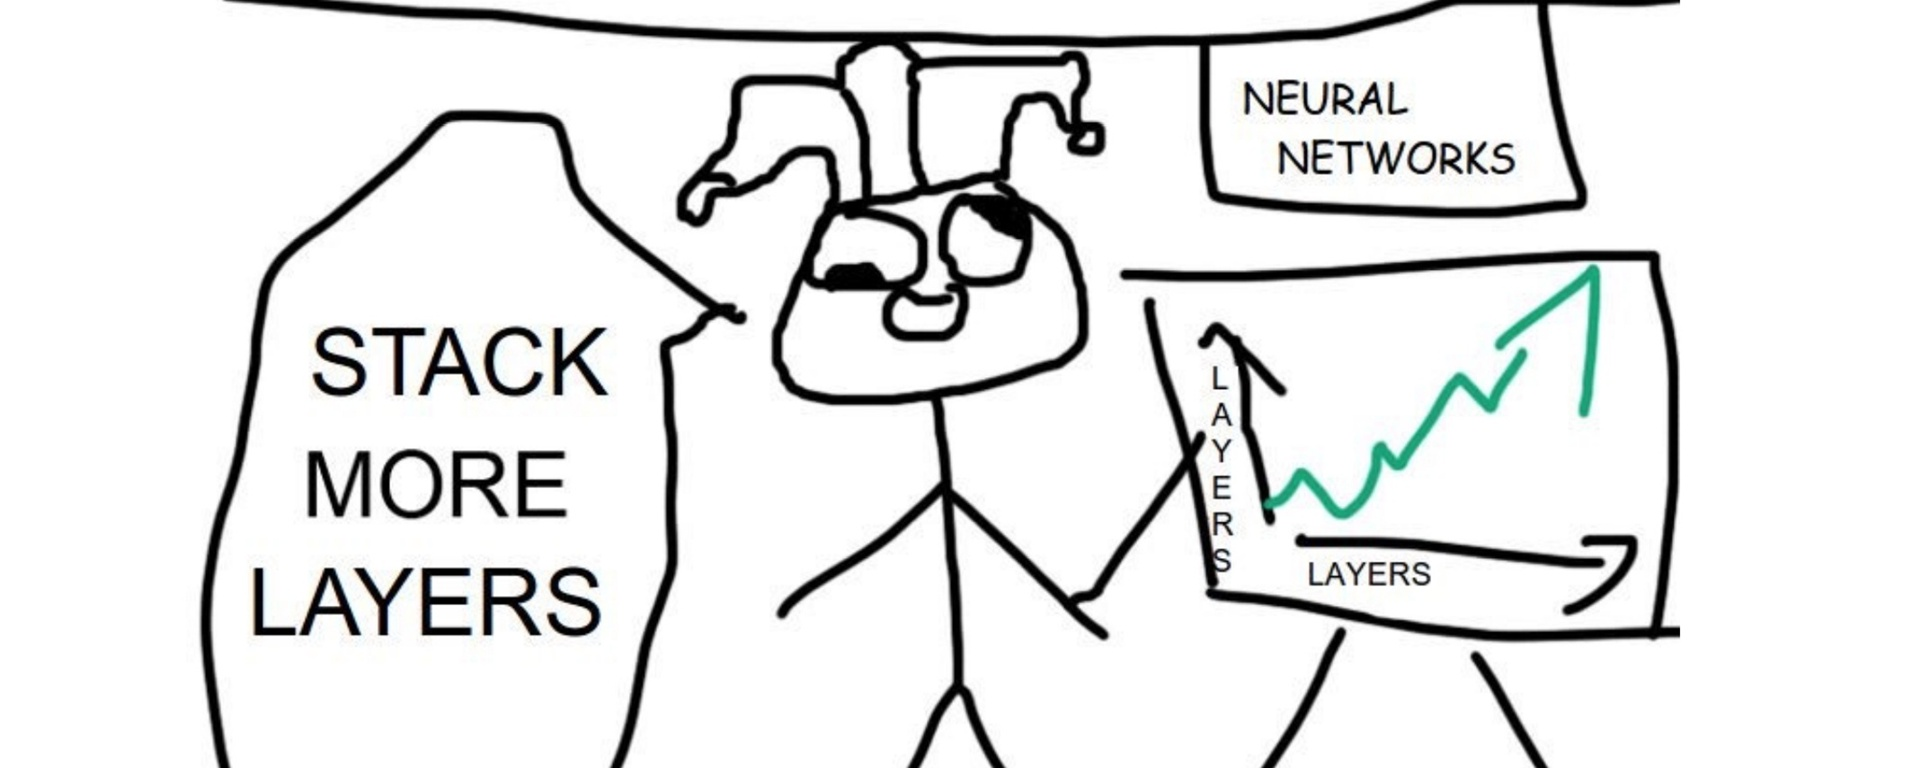

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [174]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
df = pd.read_excel("/content/drive/MyDrive/Sovcom/Test_СКБ.xlsx")
df

,Номер,Кредит_1,Кредит_2,Кредит_3,Кредит_4,Кредит_5,Кредит_6,Кредит_7,Кредит_8,Кредит_8.1,Кредит_9,Кредит_9.1,Кредит_10,Таргет
0,1,3.0,2.198148,0.454928,-61106.46,46514.59,Краснодарский край,ИП,15618.0,51000.75,112107.21,0,0,210000.0
1,2,4.0,0.724730,1.705879,15294.58,1600.00,Брянская область,Телекоммуникации,1557.0,36961.75,21667.17,0,1,85000.0
2,3,NaN,0.939573,9.215281,41286.98,NaN,Санкт-Петербург,Школы,0.0,46312.50,5025.52,0,1,180000.0
3,4,4.0,1.021181,1.718885,19795.43,451583.75,Республика Коми,Промышленность: стройматериалы,NaN,47331.50,27536.07,0,1,70000.0
4,5,4.0,4.625782,0.277769,-175373.84,6500.00,Ханты-Мансийский автономный округ,ООО,0.0,67448.50,242822.34,0,1,85000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4995,3.0,1.147187,0.805902,-12132.10,NaN,Красноярский край,Медицинские учреждения,NaN,50373.25,62505.35,0,1,70000.0
4995,4996,3.0,3.419370,0.277843,-114452.46,23020.83,Приморский край,ИП,137706.0,44034.50,158486.96,0,1,60000.0
4996,4997,4.0,1.314191,0.536169,-33212.41,54825.52,Нижегородская область,ИП,34748.0,38392.25,71604.66,0,1,140000.0
4997,4998,4.0,0.714710,2.448010,20838.08,3350.00,Москва,Государственные учреждения,151.0,35228.75,14390.67,0,1,85000.0


Хочу посмотреть на типы данных т.к не совсем понятно почему в фиче "Кредит_4" есть отрицательные значения ...

In [123]:
df.dtypes

,0
Номер,int64
Кредит_1,float64
Кредит_2,float64
Кредит_3,float64
Кредит_4,object
Кредит_5,float64
Кредит_6,object
Кредит_7,object
Кредит_8,float64
Кредит_8.1,float64


Мне кажется , что произошла какая-то ошибка , ведь если кредит отрицательный  то получется , что банк должен клиенту?..  и почему-то присвоен тип объект , хотя очевидно , что  фича принимает вещественные значения .Заменю отрицательные значения на такие же положительные и присвою тип float64

In [125]:
df['Кредит_4'] = pd.to_numeric(df['Кредит_4'].astype(str), errors='coerce')
df['Кредит_4'] = df['Кредит_4'].astype('float64')
df['Кредит_4'] = df['Кредит_4'].apply(abs)
df['Кредит_9'] = pd.to_numeric(df['Кредит_9'].astype(str), errors='coerce')
df['Кредит_9'] = df['Кредит_9'].astype('float64')

Гляну на описание фичей

In [126]:
df.describe()

,Номер,Кредит_1,Кредит_2,Кредит_3,Кредит_4,Кредит_5,Кредит_8,Кредит_8.1,Кредит_9,Кредит_9.1,Кредит_10,Таргет
count,4999.000000,4085.000000,4999.000000,4.999000e+03,4997.000000,4.645000e+03,4.619000e+03,4999.000000,4996.000000,4999.000000,4999.000000,4999.000000
mean,2500.000000,3.625949,1.548032,9.397917e+03,46430.550806,5.278782e+04,2.645150e+04,46365.173441,64437.110074,0.213643,0.667734,107712.222058
std,1443.231328,0.983265,1.225048,6.855636e+04,53819.313523,1.486335e+05,6.018733e+04,17792.429554,69606.285394,0.409918,0.471073,71640.909952
min,1.000000,1.000000,0.431052,6.258603e-02,8.170000,0.000000e+00,0.000000e+00,21079.250000,0.000000,0.000000,0.000000,21000.000000
25%,1250.500000,3.000000,0.769379,5.141636e-01,14653.050000,1.197868e+04,3.035500e+03,35355.500000,17190.407500,0.000000,0.000000,56000.000000
50%,2500.000000,4.000000,1.028120,1.087555e+00,28864.130000,2.586546e+04,1.419500e+04,40941.750000,39799.065000,0.000000,1.000000,88000.000000
75%,3749.500000,4.000000,1.929559,2.513641e+00,52674.290000,5.057430e+04,3.171400e+04,51000.750000,85713.197500,0.000000,1.000000,140000.000000
max,4999.000000,5.000000,8.679215,1.187170e+06,365430.220000,6.726371e+06,1.635704e+06,140567.500000,399626.470000,1.000000,1.000000,400000.000000


Фича 'Кредит_9.1' очень разреженная ее выкину, поскольку есть пропуски в данных и категориальные фичи в качестве модели выберу catboost

In [127]:
df = df.drop('Кредит_9.1',axis =1)

In [128]:
df

,Номер,Кредит_1,Кредит_2,Кредит_3,Кредит_4,Кредит_5,Кредит_6,Кредит_7,Кредит_8,Кредит_8.1,Кредит_9,Кредит_10,Таргет
0,1,3.0,2.198148,0.454928,61106.46,46514.59,Краснодарский край,ИП,15618.0,51000.75,112107.21,0,210000.0
1,2,4.0,0.724730,1.705879,15294.58,1600.00,Брянская область,Телекоммуникации,1557.0,36961.75,21667.17,1,85000.0
2,3,NaN,0.939573,9.215281,41286.98,NaN,Санкт-Петербург,Школы,0.0,46312.50,5025.52,1,180000.0
3,4,4.0,1.021181,1.718885,19795.43,451583.75,Республика Коми,Промышленность: стройматериалы,NaN,47331.50,27536.07,1,70000.0
4,5,4.0,4.625782,0.277769,175373.84,6500.00,Ханты-Мансийский автономный округ,ООО,0.0,67448.50,242822.34,1,85000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4995,3.0,1.147187,0.805902,12132.10,NaN,Красноярский край,Медицинские учреждения,NaN,50373.25,62505.35,1,70000.0
4995,4996,3.0,3.419370,0.277843,114452.46,23020.83,Приморский край,ИП,137706.0,44034.50,158486.96,1,60000.0
4996,4997,4.0,1.314191,0.536169,33212.41,54825.52,Нижегородская область,ИП,34748.0,38392.25,71604.66,1,140000.0
4997,4998,4.0,0.714710,2.448010,20838.08,3350.00,Москва,Государственные учреждения,151.0,35228.75,14390.67,1,85000.0


Посмотрю на категориальные фичи

In [129]:
df['Кредит_6'].unique()

array(['Краснодарский край', 'Брянская область', 'Санкт-Петербург',
       'Республика Коми', 'Ханты-Мансийский автономный округ',
       'Волгоградская область', 'Республика Марий Эл',
       'Ставропольский край', 'Сахалинская область',
       'Новосибирская область', 'Кемеровская область',
       'Челябинская область', 'Республика Калмыкия', 'Кировская область',
       'Удмуртская Республика', 'Магаданская область',
       'Ростовская область', 'Красноярский край', 'Москва',
       'Республика Дагестан', 'Оренбургская область', 'Омская область',
       'Алтайский край', 'Свердловская область', 'Республика Карелия',
       'Ивановская область', 'Владимирская область', 'Тюменская область',
       'Курская область', 'Астраханская область', 'Белгородская область',
       'Республика Татарстан', 'Липецкая область', 'Воронежская область',
       'Нижегородская область', 'Чувашская Республика',
       'Самарская область', 'Республика Башкортостан', 'Тульская область',
       nan, 'Республи

In [130]:
df['Кредит_6'].value_counts()

,count
Кредит_6,
Москва,416
Краснодарский край,271
Санкт-Петербург,200
Московская область,199
Новосибирская область,198
...,...
Еврейская автономная область,8
Магаданская область,7
Республика Дагестан,7


Видно , что в датасете очень много примеров из Москвы , скорее всего люди из Москвы окажутся выше по номеру группы после ранжирования таргета

In [131]:
df['Кредит_7'].unique()

array(['ИП', 'Телекоммуникации', 'Школы',
       'Промышленность: стройматериалы', 'ООО', 'Прочее',
       'Медицинские учреждения', 'Торговля: крупная ТС продукты',
       'Торговля: магазины', 'Государственные учреждения', 'ОАО',
       'Промышленность: остальное', 'Охрана', 'Военные',
       'Промышленность: пищевая', 'Промышленность: добывающая',
       'Транспорт', 'Силовые структуры', 'ВУЗы и НИИ', 'Строительство',
       'Гостиницы и пансионаты', 'Полиция', 'Детские сады',
       'Промышленность: тяжелая', 'Реклама и СМИ', 'Банк',
       'Промышленность: химическая', 'ЗАО', 'Риэлторские компании',
       'Сельское хозяйство', 'Промышленность: машиностроение', 'МЧС',
       'Аэропорты', 'Промышленность: фармацевтика', 'Торговля: аптеки',
       'ЖКХ', 'Почта', 'Промышленность: мебельная', 'РЖД', 'Такси',
       'Юридические услуги', 'Электростанции', 'Культура',
       'Кафе, рестораны', 'Торговля: крупная ТС техника', 'Страхование',
       'Торговля: крупная ТС одежда/спорт', 'С

In [132]:
df['Кредит_7'].value_counts()

,count
Кредит_7,
ООО,1233
Прочее,1075
ИП,750
Медицинские учреждения,211
Школы,175
Государственные учреждения,171
Промышленность: добывающая,149
Транспорт,111
Строительство,100


Очень сильный перевес примеров 'ООО' , 'Прочее' и 'ИП', с учетом того что в датасете есть явный дизбаланс примеров по категариальным значениям можно предположить , что в будующем ошибки в тех или иных группах по заработку будут связаны с недостаточным колличеством примеров

Проверю наличие дубликатов и избавлюсь от них , если они есть

In [133]:
df.duplicated().any()

np.False_

Дубликатов нет.

Заполнение пропусков оставлю на catboost

In [134]:
df.isna().sum()

,0
Номер,0
Кредит_1,914
Кредит_2,0
Кредит_3,0
Кредит_4,2
Кредит_5,354
Кредит_6,104
Кредит_7,0
Кредит_8,380
Кредит_8.1,0


Отделю целевую переменную

In [135]:
y = df['Таргет']
X = df.drop('Таргет', axis=1)
X = X.drop('Номер',axis=1)

Сплитану датасет на трейн и тест

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Отмасштабирую вещественные признаки

In [137]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data_scaler = scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = data_scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] =  data_scaler.transform(X_test[numeric_cols])

In [138]:
X_train

,Кредит_1,Кредит_2,Кредит_3,Кредит_4,Кредит_5,Кредит_6,Кредит_7,Кредит_8,Кредит_8.1,Кредит_9,Кредит_10
4703,0.371625,-0.768615,-0.132139,-0.351342,NaN,Саратовская область,ИП,NaN,-0.846739,-0.880277,-1.402972
2364,0.371625,-0.646857,6.005407,-0.165314,NaN,Брянская область,ООО,NaN,-0.497377,-0.932749,0.712773
2043,0.371625,-0.670500,-0.132257,-0.698658,-0.190688,Рязанская область,Банк,-0.061699,-0.697174,-0.574478,0.712773
1353,-1.660370,-0.624164,-0.132260,-0.728136,-0.219324,Республика Адыгея,Банк,-0.142462,-0.421328,-0.480315,0.712773
2526,0.371625,-0.702288,-0.132260,-0.763357,NaN,Кемеровская область,Промышленность: нефтепереработка,-0.438249,-0.683140,-0.521096,0.712773
...,...,...,...,...,...,...,...,...,...,...,...
1706,0.371625,3.110352,-0.132278,2.845527,-0.196143,Псковская область,ООО,0.156660,-0.843857,2.380793,0.712773
3297,-0.644372,-0.421635,-0.132261,-0.744825,-0.212336,Краснодарский край,ООО,-0.216934,0.257401,-0.291558,0.712773
1217,NaN,-0.589631,-0.132261,-0.783300,-0.202803,Ростовская область,Прочее,-0.056886,-0.305597,-0.407905,-1.402972
2419,NaN,-0.744504,-0.132159,-0.356686,NaN,Ульяновская область,Прочее,NaN,-0.824617,-0.870433,-1.402972


Фичам с типом object присвою тип category, пропущенные значения в категориях заполню строками

In [139]:
category_columns = X_train.select_dtypes(include=['object']).columns.tolist()
X_train[category_columns] = X_train[category_columns].fillna("missing")
X_test[category_columns] = X_test[category_columns].fillna("missing")
X_train[category_columns] = X_train[category_columns].astype('category')
X_test[category_columns] = X_test[category_columns].astype('category')

In [140]:
category_columns

['Кредит_6', 'Кредит_7']

Вещественные признаки отмасштабировал , теперь перейду к моделированию

Попробую в качестве функционала передать catboost-у MAPE потому что эта метрика является основной в задании

In [153]:
cat_features = ['Кредит_6', 'Кредит_7']
train_pool = Pool(X_train, y_train, cat_features=cat_features)

model = CatBoostRegressor(
    loss_function='MAPE',
)

model.fit(train_pool, eval_set=train_pool, plot=True)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4553373	test: 0.4553373	best: 0.4553373 (0)	total: 41.8ms	remaining: 41.8s
1:	learn: 0.4552632	test: 0.4552632	best: 0.4552632 (1)	total: 65.7ms	remaining: 32.8s
2:	learn: 0.4550556	test: 0.4550556	best: 0.4550556 (2)	total: 94.8ms	remaining: 31.5s
3:	learn: 0.4550006	test: 0.4550006	best: 0.4550006 (3)	total: 104ms	remaining: 26s
4:	learn: 0.4549641	test: 0.4549641	best: 0.4549641 (4)	total: 111ms	remaining: 22s
5:	learn: 0.4547502	test: 0.4547502	best: 0.4547502 (5)	total: 117ms	remaining: 19.5s
6:	learn: 0.4544909	test: 0.4544909	best: 0.4544909 (6)	total: 124ms	remaining: 17.5s
7:	learn: 0.4543356	test: 0.4543356	best: 0.4543356 (7)	total: 130ms	remaining: 16.1s
8:	learn: 0.4541493	test: 0.4541493	best: 0.4541493 (8)	total: 137ms	remaining: 15.1s
9:	learn: 0.4540077	test: 0.4540077	best: 0.4540077 (9)	total: 143ms	remaining: 14.2s
10:	learn: 0.4539031	test: 0.4539031	best: 0.4539031 (10)	total: 153ms	remaining: 13.7s
11:	learn: 0.4538502	test: 0.4538502	best: 0.4538502 

На тесте модель  показала удовлетворительное качество , теперь посмотрим на ошибку в разных группах

In [154]:
mean_absolute_percentage_error(y_test,test_preds)

0.44641997724848825

Теперь отранжирую предсказания модели на тесте и разобью их на 10 групп , посмотри в какой группе будет самая большая ошибка. Для этого создам датасет с истинным значением и предсказанным

In [156]:
dataset_for_10_groups = pd.DataFrame({'true': y_test, 'pred': test_preds})
dataset_for_10_groups = dataset_for_10_groups.sort_values(by='pred')

In [158]:
dataset_for_10_groups['decile'] = pd.qcut(
    dataset_for_10_groups['pred'],
    q=10,
    labels=False
)

In [160]:
def calculate_mape_sklearn(group):
    return mean_absolute_percentage_error(group['true'], group['pred'])

/tmp/ipython-input-164-2655428176.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_results = dataset_for_10_groups.groupby('decile').apply(calculate_mape_sklearn).reset_index(name='MAPE')


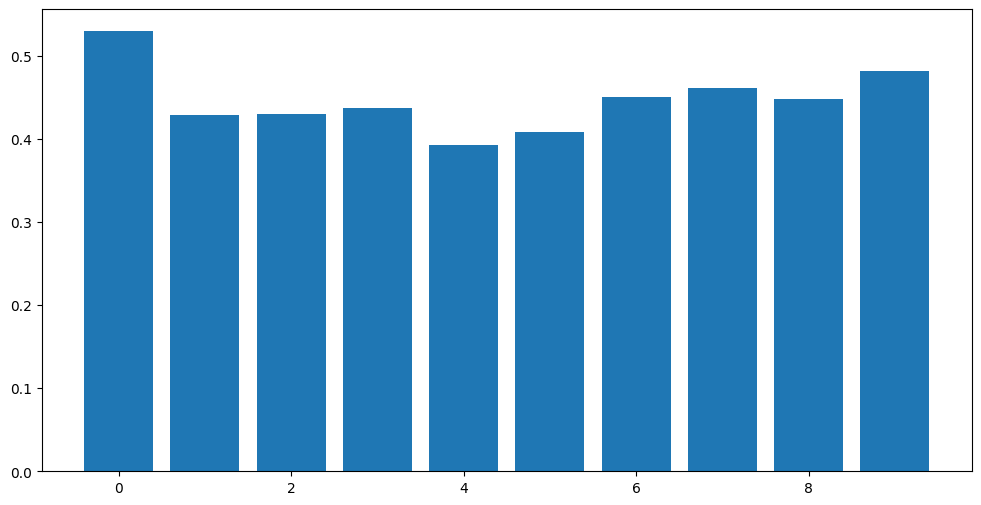

In [164]:
mape_results = dataset_for_10_groups.groupby('decile').apply(calculate_mape_sklearn).reset_index(name='MAPE')
plt.figure(figsize=(12, 6))
bars = plt.bar(mape_results['decile'], mape_results['MAPE'])

Можно увидеть , что в среднем модель ошибается на всех группах +- одинаково , но выделяется 0 группа (наименьший заработок). Из того что я видел ранее больше всего примеров в датасете было людей из москвы и других крупных и регионов ,а по роду дейтельности было больше всего примеров ООО , ИП и ИНОЕ , что может говорить о том , что в датасете просто больше примеров людей с средним/высоким  заработком о чем также может говорить наименьшая ошибка в 4 и 5 группах

К тестовому датасету добавлю колонку с предсказанными значениями , затем отранжирую его по таргету и посмотрю на то какие люди попали в 0 группу

In [165]:
X_test['predicted_value'] = test_preds

In [166]:
X_test = X_test.sort_values(by='predicted_value')

In [168]:
X_test['decile'] = pd.qcut(
    X_test['predicted_value'],
    q=10,
    labels=False
)

Решил посмотреть на топ и антитоп 5 самых больших предиктов в датасете в зависимости от значений категориальных переменных, теперь можно будет сделать четкие выводы по 0 группе

In [177]:
mean_preds_6 = X_test.groupby('Кредит_6')['predicted_value'].mean().sort_values(ascending=False)
mean_preds_7 = X_test.groupby('Кредит_7')['predicted_value'].mean().sort_values(ascending=False)
top_cats_6 = mean_preds_6.head(5).index.tolist()
bottom_cats_6 = mean_preds_6.tail(5).index.tolist()
top_cats_7 = mean_preds_7.head(5).index.tolist()
bottom_cats_7 = mean_preds_7.tail(5).index.tolist()

/tmp/ipython-input-177-1324963281.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_preds_6 = X_test.groupby('Кредит_6')['predicted_value'].mean().sort_values(ascending=False)
/tmp/ipython-input-177-1324963281.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_preds_7 = X_test.groupby('Кредит_7')['predicted_value'].mean().sort_values(ascending=False)


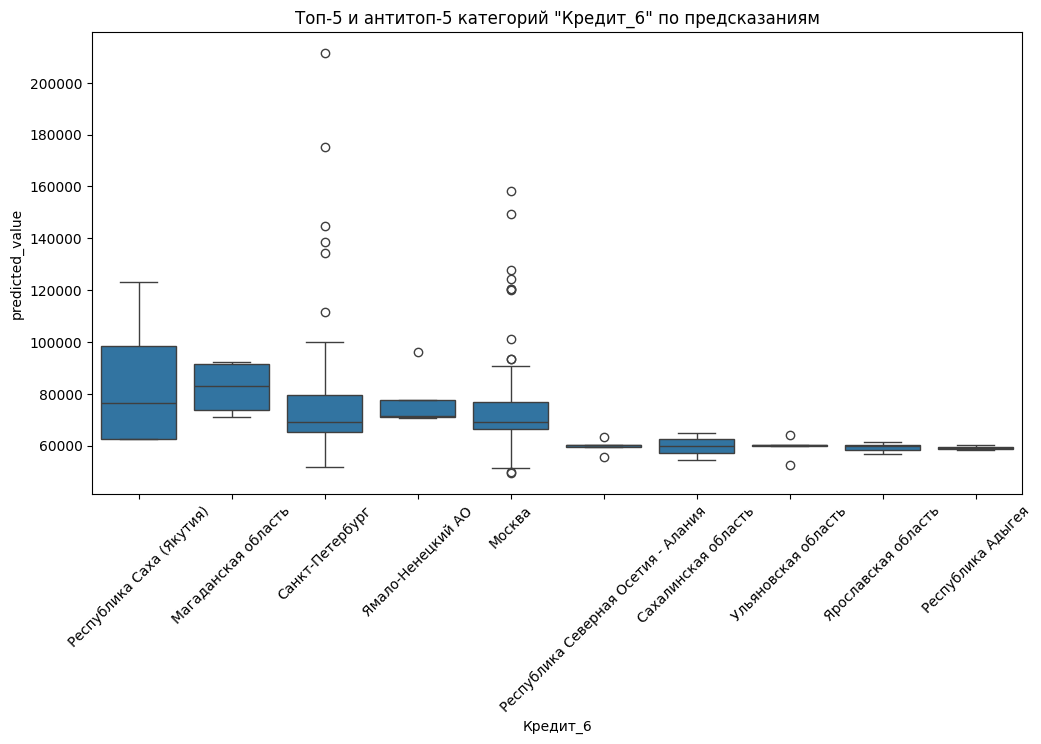

In [179]:
filtered_data_6 = X_test[X_test['Кредит_6'].isin(top_cats_6 + bottom_cats_6)]
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=filtered_data_6,
    x='Кредит_6',
    y='predicted_value',
    order=top_cats_6 + bottom_cats_6
)
plt.title('Топ-5 и антитоп-5 категорий "Кредит_6" по предсказаниям')
plt.xticks(rotation=45)
plt.show()

Собственно в 0 группе нет примеров из топ регионов по доходу -> можно сказать, а те регионы которые есть в 0 группе не входят в число регионов с большим колличеством примеров в датасете

In [181]:
X_test[X_test['decile'] ==0]['Кредит_6'].value_counts()

,count
Кредит_6,
Алтайский край,8
Оренбургская область,6
Новосибирская область,6
Московская область,6
Кемеровская область,5
...,...
Тамбовская область,0
Томская область,0
Смоленская область,0


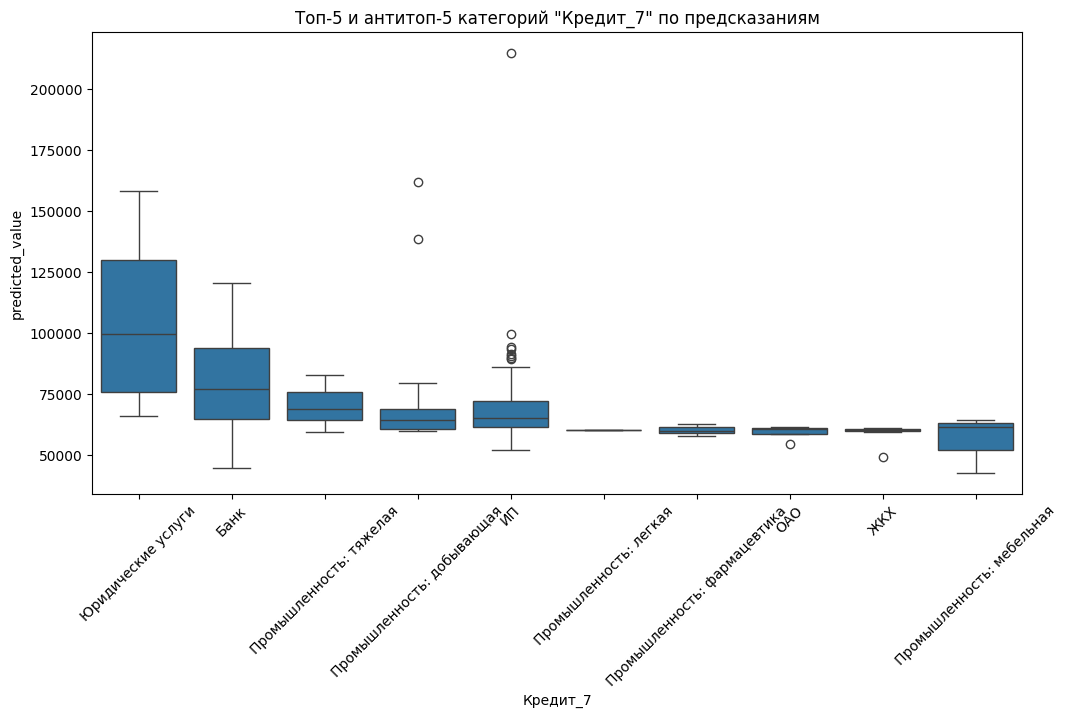

In [180]:
filtered_data_7 = X_test[X_test['Кредит_7'].isin(top_cats_7 + bottom_cats_7)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=filtered_data_7,
    x='Кредит_7',
    y='predicted_value',
    order=top_cats_7 + bottom_cats_7
)
plt.title('Топ-5 и антитоп-5 категорий "Кредит_7" по предсказаниям')
plt.xticks(rotation=45)
plt.show()

В 0 группе нет ни одного примера из топового рода деятельности по доходу да и входят в 0 группу не самые распространненые категории из всего датасета

In [172]:
X_test[X_test['decile'] ==0]['Кредит_7'].value_counts()

,count
Кредит_7,
Прочее,75
ООО,10
ИП,9
Школы,4
Государственные учреждения,4
Медицинские учреждения,3
Торговля: магазины,3
Сельское хозяйство,2
Военные,1


In [186]:
X_test[X_test['decile'] ==0].shape

(125, 13)

Можно сделать вывод , что 0 группа имеет наибольшую ошибку из-за того что в датасете просто напросто не так много примеров людей из отдаленных от центральной части регионов(топовых регионов по заработку) и не так много примеров людей чьи профессии не имеют возможности зарабатывать также много как теже предпрениматели